# Compare fits to mock data using different emulators

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import mock_data
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Setup emulators

Each run will have its own emulator, that will be the only different thing in the run

In [2]:
# setup run for Pedersen21 emulator
runs={}
runs['Pedersen21']={'emulator':gp_emulator.GPEmulator(training_set='Pedersen21',emulator_label='Pedersen21')}

Selected training set from Pedersen21
Select emulator in Pedersen21
Gaussian Process emulator predicting the P1D at each k-bin. It goes to scales of 3Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones.


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 1.32 seconds


In [3]:
# setup run for Pedersen23 emulator
runs['Pedersen23']={'emulator':gp_emulator.GPEmulator(training_set='Pedersen21',emulator_label='Pedersen23')}

Selected training set from Pedersen21
Select emulator in Pedersen23
Gaussian Process emulator predicting the P1D, fitting coefficients to a 4th degree polynomial. It goes to scales of 3Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Training GP on 330 points
GPs optimised in 0.59 seconds


In [4]:
# setup run for Cabayol23 NN emulator
runs['Cabayol23']={'emulator':nn_emulator.NNEmulator(training_set='Cabayol23',emulator_label='Cabayol23')}

Selected training set from Cabayol23
Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones


In [5]:
# setup run for the Nyx emulator
runs['Nyx']={'emulator':nn_emulator.NNEmulator(training_set='Nyx23',emulator_label='Cabayol23_Nyx')}

Selected training set from Nyx23
Select emulator in Cabayol23_Nyx
Neural network emulating the optimal P1D of Nyx simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones


### Create mock P1D data

Create mock data, mimicking a particular dataset, using the emulator to create the signal

In [6]:
data_label="Chabanier2019"

In [7]:
for label,run in runs.items():
    print('label',label)
    run['data']=mock_data.Mock_P1D(emulator=run['emulator'],data_label=data_label)

label Pedersen21
label Pedersen23
label Cabayol23
label Nyx


Pedersen21


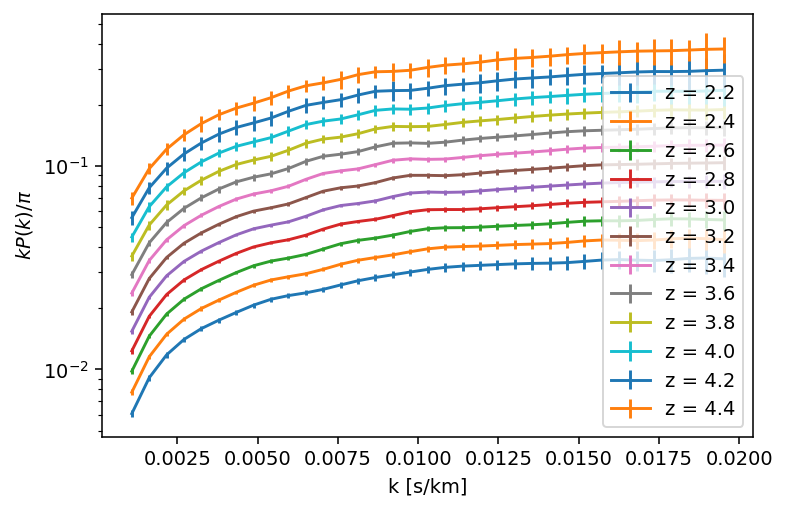

Pedersen23


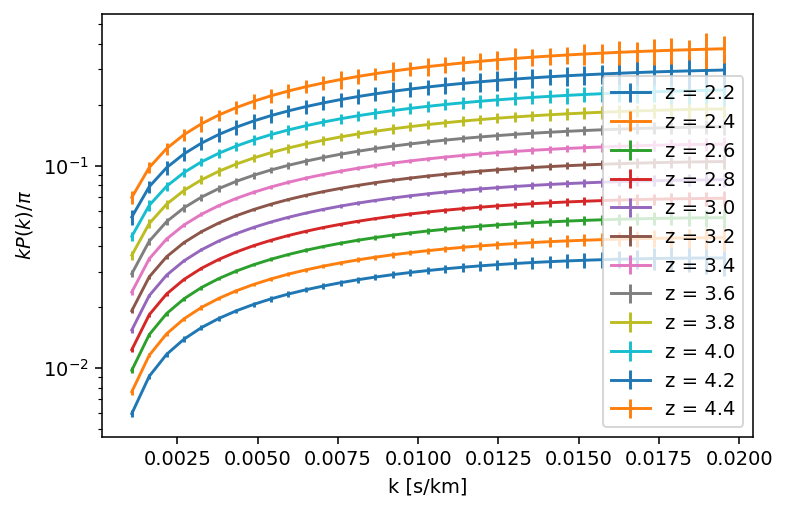

Cabayol23


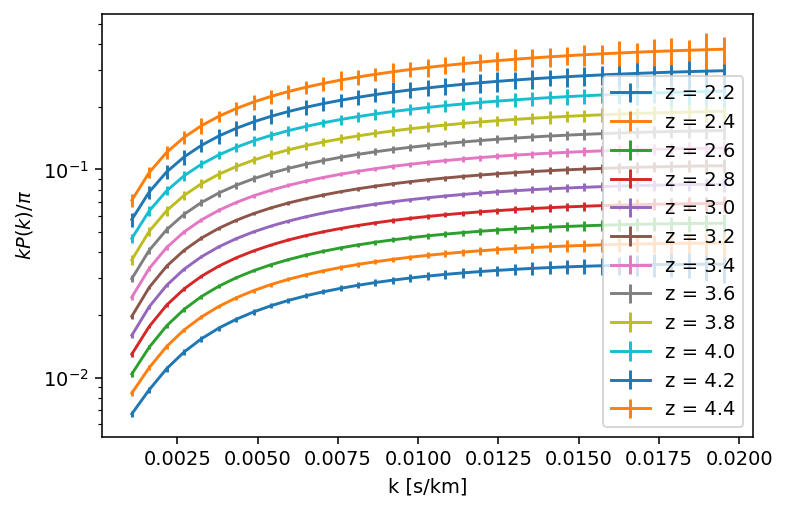

Nyx


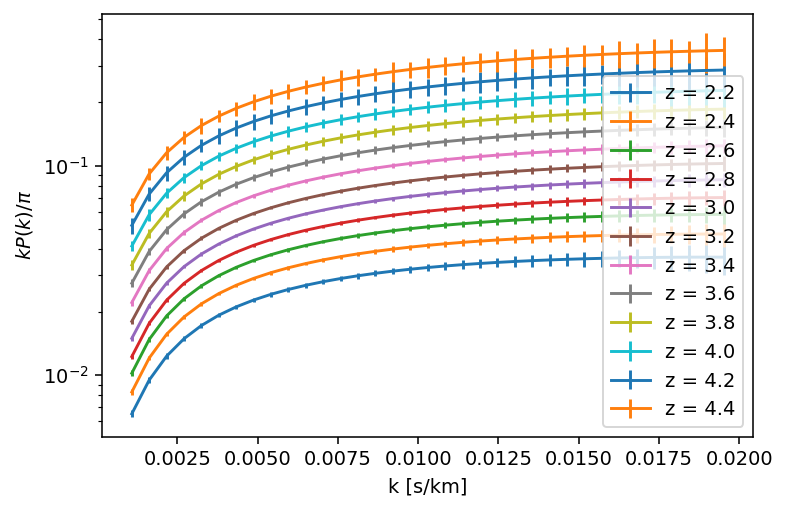

In [8]:
for label,run in runs.items():
    data=run['data']
    print(label)
    data.plot_p1d()

### Set free parameters and theory

In [9]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=1
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [10]:
for label,run in runs.items():
    run['theory']=lya_theory.Theory(zs=run['data'].z,emulator=run['emulator'],free_param_names=free_param_names)

### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and theory objects to the likelihood.

In [11]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
for label,run in runs.items():
    run['likelihood']=like=likelihood.Likelihood(data=run['data'],theory=run['theory'],
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor)

run Pedersen21
As = 2.0999999999999998e-09 , 1e-09 , 3.2e-09
ns = 0.9650000000000001 , 0.88 , 1.05
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_kF_0 = 0.0 , -0.2 , 0.2
chi2 = -0.0


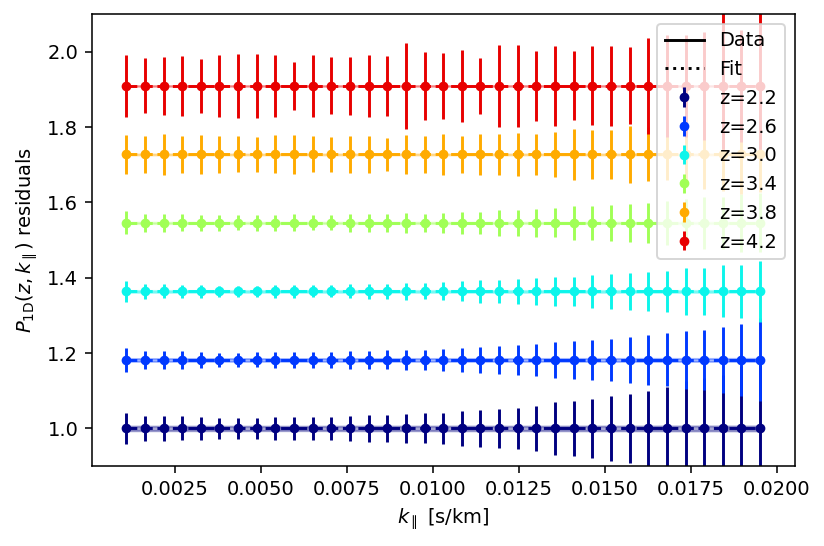

----------------
run Pedersen23
As = 2.0999999999999998e-09 , 1e-09 , 3.2e-09
ns = 0.9650000000000001 , 0.88 , 1.05
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_kF_0 = 0.0 , -0.2 , 0.2
chi2 = -0.0


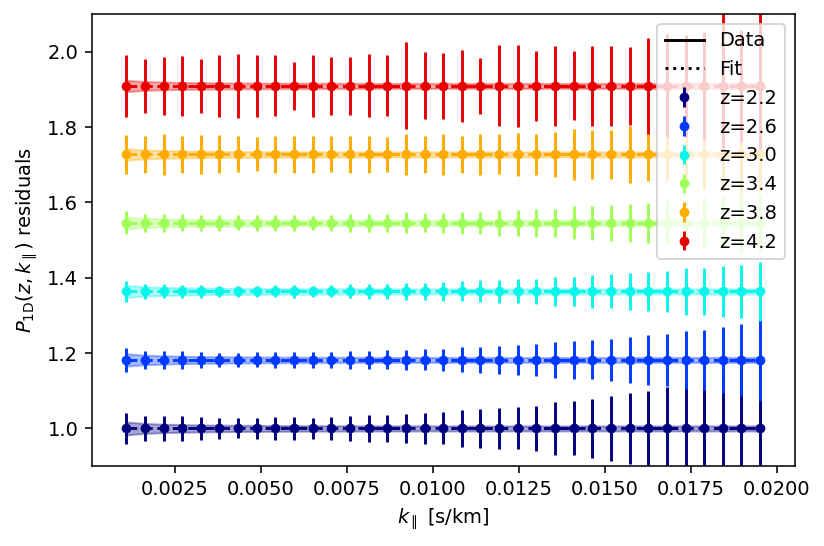

----------------
run Cabayol23
As = 2.0999999999999998e-09 , 1e-09 , 3.2e-09
ns = 0.9650000000000001 , 0.88 , 1.05
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_kF_0 = 0.0 , -0.2 , 0.2
chi2 = -0.0


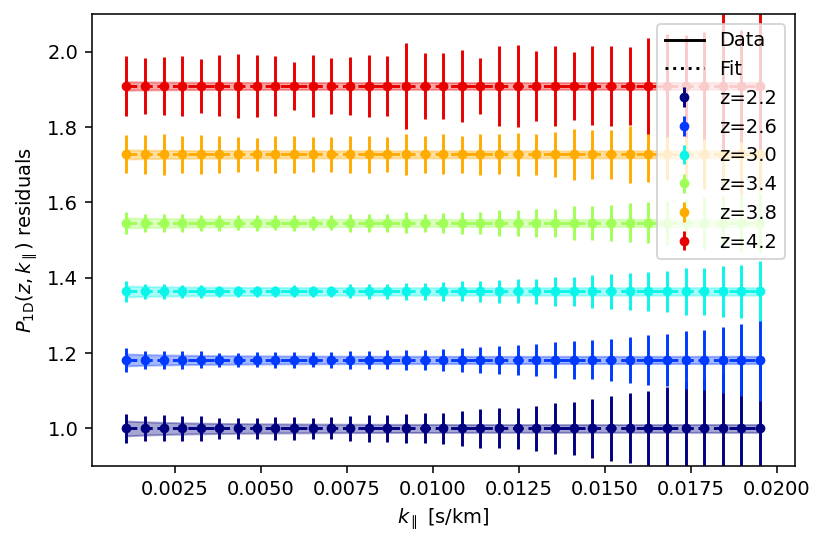

----------------
run Nyx
As = 2.0999999999999998e-09 , 1e-09 , 3.2e-09
ns = 0.9650000000000001 , 0.88 , 1.05
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_kF_0 = 0.0 , -0.2 , 0.2
chi2 = -0.0


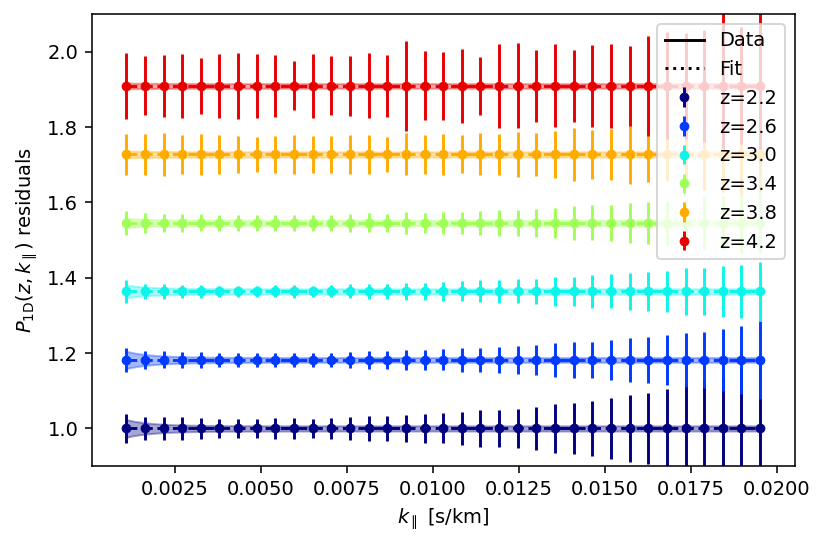

----------------


In [12]:
# check starting point for free parameters (should be equal to truth)
test_values=len(free_param_names)*[0.5]
for label,run in runs.items():
    print('run',label)
    like=run['likelihood']
    for p in like.parameters_from_sampling_point(values=test_values):
        print(p.info_str(all_info=True))
    print('chi2 =',like.get_chi2(values=test_values))
    like.plot_p1d(values=test_values,residuals=True,plot_every_iz=2)
    print('----------------')

### Run iminuit minimizer

In [13]:
# choose starting point for free parameters (within 0.5 +/- ini_sigma, in the unit cube)
ini_sigma=0.02
ini_values=2*ini_sigma*np.random.random(len(free_param_names))+0.5-ini_sigma
for label,run in runs.items():
    print('minimize run',label)
    # what is the chi2 of the starting point?
    ini_chi2=run['likelihood'].get_chi2(values=ini_values)
    run['minimizer']=iminuit_minimizer.IminuitMinimizer(run['likelihood'],ini_values=ini_values)
    run['minimizer'].minimize(compute_hesse=True)
    # what is the chi2 of the best-fit? (should be close to 0)
    best_fit_values=np.array(run['minimizer'].minimizer.values)
    best_chi2=run['likelihood'].get_chi2(values=best_fit_values)
    print('chi2 improved from {} to {}'.format(ini_chi2,best_chi2)) 

minimize run Pedersen21
chi2 improved from 0.11369669582265898 to 2.169383130950567e-05
minimize run Pedersen23
chi2 improved from 0.13582407734576005 to 6.982810762460192e-06
minimize run Cabayol23
chi2 improved from 0.12217402823243635 to 3.31177586642007e-05
minimize run Nyx
chi2 improved from 0.026120140713708873 to 1.478703877639081e-05


run Pedersen21


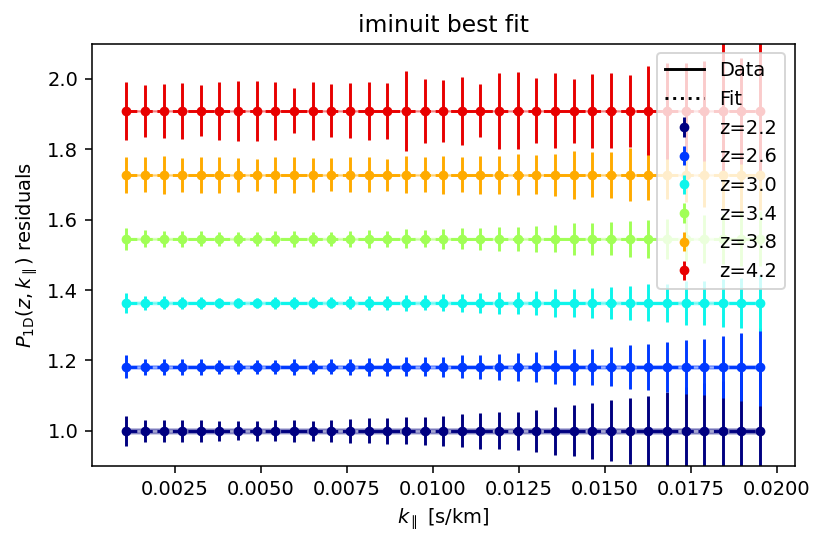

run Pedersen23


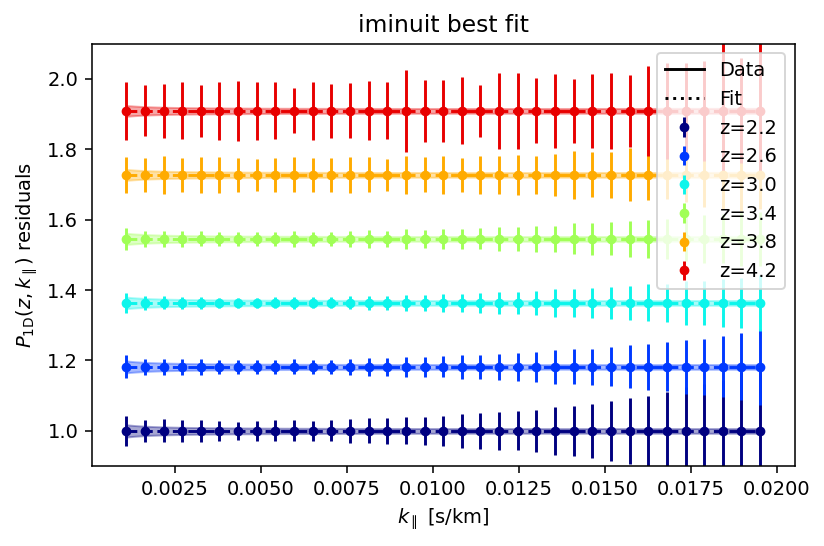

run Cabayol23


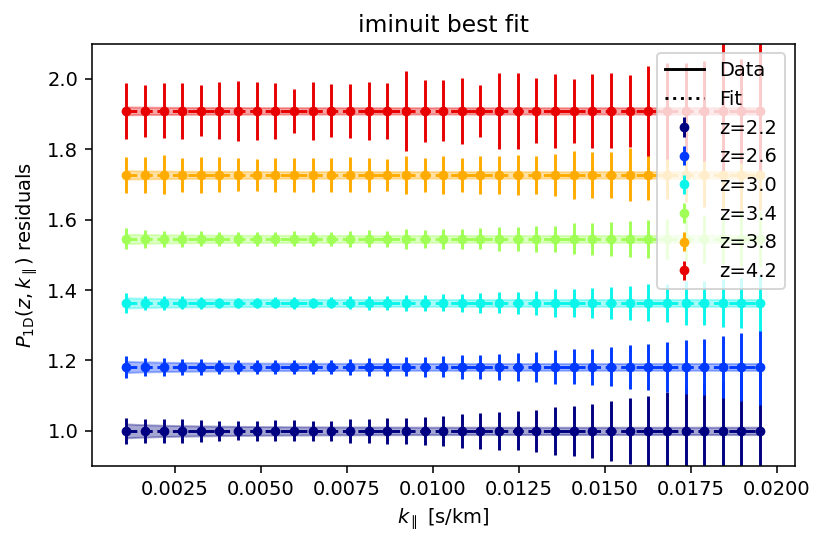

run Nyx


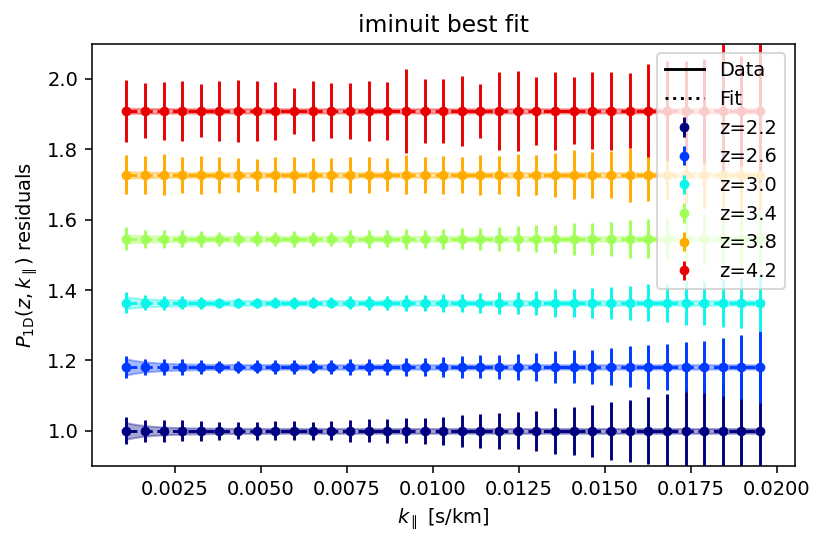

In [14]:
for label,run in runs.items():
    print('run',label)
    run['minimizer'].plot_best_fit(plot_every_iz=2)

run Pedersen21
run Pedersen23
run Cabayol23
run Nyx


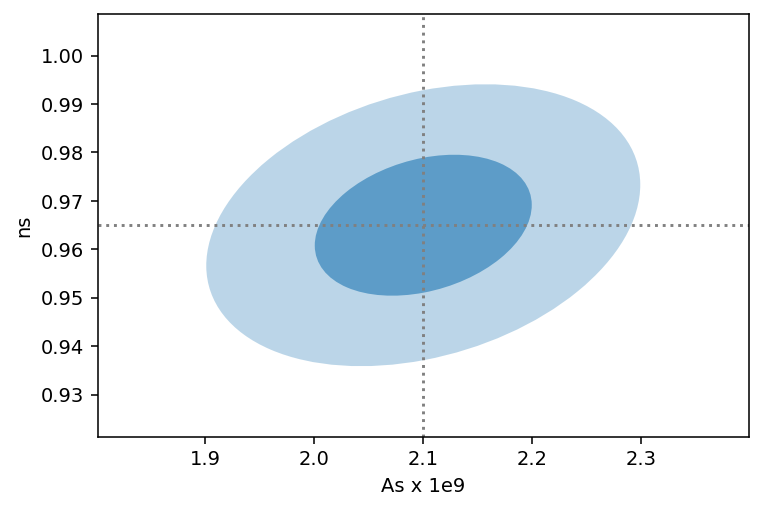

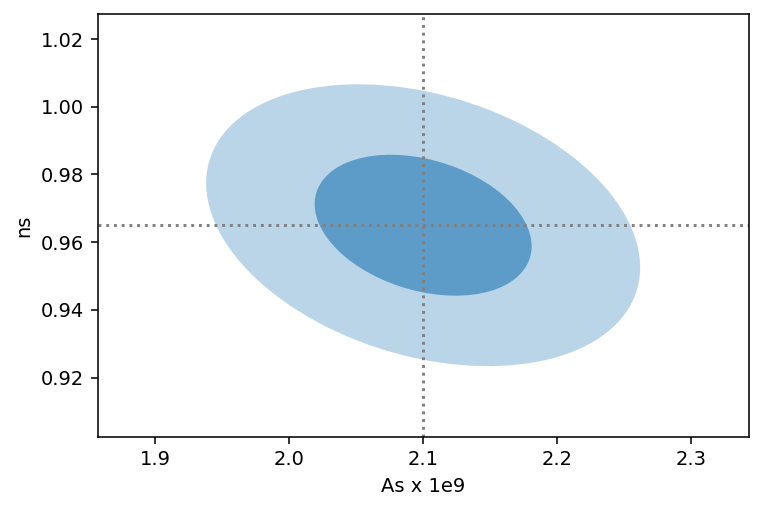

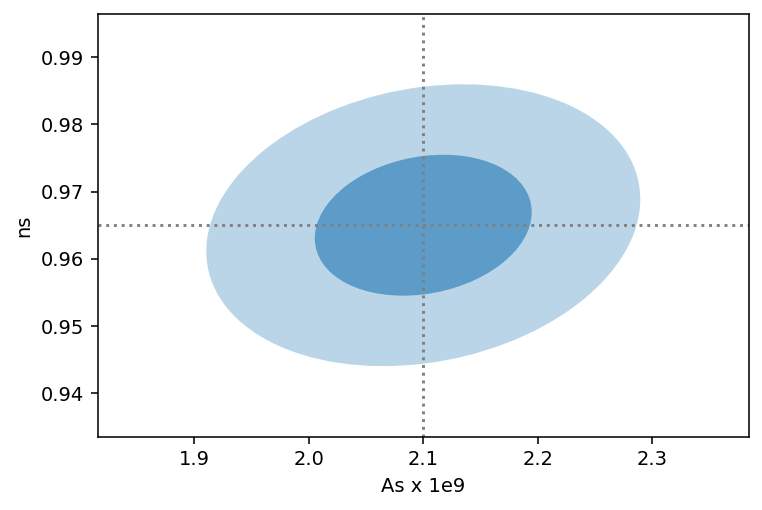

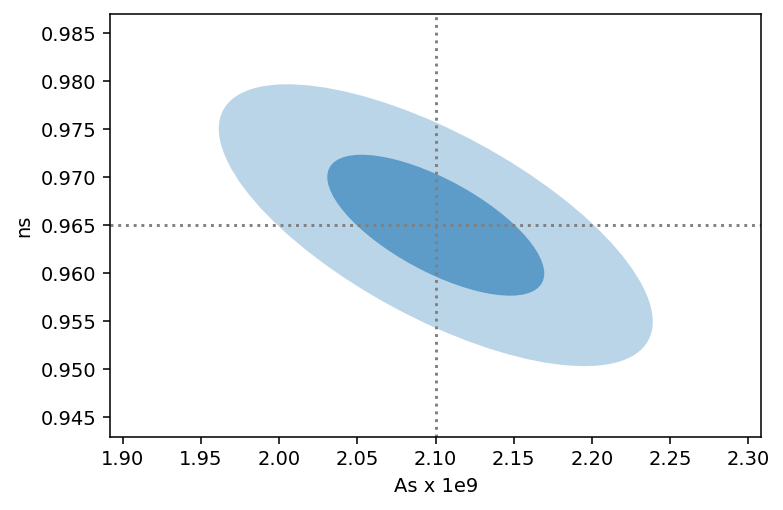

In [15]:
for label,run in runs.items():
    plt.figure()
    print('run',label)
    run['minimizer'].plot_ellipses('As','ns')
    plt.savefig(label+'_As_ns.png')